In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
# !pip install pyserial

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cupyck
import primo.models
import primo.tools.sequences as seqtools

# TRAIN

## Predictor

In [4]:
cupyck_sess = cupyck.GPUSession(max_seqlen=200, nblocks=1024, nthreads=128)

In [5]:
simulator = primo.models.Simulator(cupyck_sess)

In [6]:
# Generate two random DNA sequences. First by creating a random sequence, then copying that sequence to another sequence, then mutating that second sequence at some given mutation rate, such that 
# the hamming distance between the sequences (i.e. how different they are) is sampled from a uniform distribution. This means that we could expect sequence that are nearly identical, and sequence pairs that are entirely opposite to occur at approximately the same rate. 
# Random_pairs: (arbitrary_sequence_1, arbitrary_sequence_2)

# Generate 5,000 of these arbitrary sequence pairs
# ...of length 80 nucleotides each (80 was chosen because that's the length of the DNA sequence's feature region in callie original paper).
random_pairs, mut_rates = seqtools.random_mutant_pairs(5000, 80)


In [7]:
# From here, we take the first arbitrary sequence, and its mutation (i.e. the random pairs), then we pretend that the first arbitrary sequence (i.e. at index 0) is a target DNA sequence, then we pretend the second arbitrary sequence (i.e. at index 1) is a query DNA sequences. 
seq_pairs = pd.DataFrame({
    "target_features": random_pairs[:, 0],
    "query_features": random_pairs[:, 1]
})


In [8]:
# Use NUPACK/CUPYCK to simulate the hybdrization yields of the two sequences in the pair (this is the Pink flow in the above diagram). 
sim_results = simulator.simulate(seq_pairs)


In [9]:
predictor = primo.models.Predictor()

In [10]:
onehot_seq_pairs = predictor.seq_pairs_to_onehots(seq_pairs)

In [13]:
history = predictor.train(onehot_seq_pairs, sim_results.duplex_yield, epochs=50, validation_split = 0.2)

Train on 4000 samples, validate on 1000 samples
Epoch 1/50
4000/4000 [==============================] - 9s 2ms/sample - loss: 0.4221 - val_loss: 0.2713
Epoch 2/50
4000/4000 [==============================] - 1s 206us/sample - loss: 0.2403 - val_loss: 0.2164
Epoch 3/50
4000/4000 [==============================] - 1s 216us/sample - loss: 0.2178 - val_loss: 0.2199
Epoch 4/50
4000/4000 [==============================] - 1s 211us/sample - loss: 0.2144 - val_loss: 0.2069
Epoch 5/50
4000/4000 [==============================] - 1s 213us/sample - loss: 0.2129 - val_loss: 0.2082
Epoch 6/50
4000/4000 [==============================] - 1s 215us/sample - loss: 0.2120 - val_loss: 0.2077
Epoch 7/50
4000/4000 [==============================] - 1s 212us/sample - loss: 0.2116 - val_loss: 0.2049
Epoch 8/50
4000/4000 [==============================] - 1s 205us/sample - loss: 0.2104 - val_loss: 0.2023
Epoch 9/50
4000/4000 [==============================] - 1s 210us/sample - loss: 0.2090 - val_loss: 0.2073


In [14]:
pred_yield = predictor.model.predict(onehot_seq_pairs)

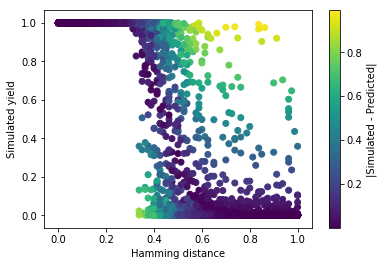

In [15]:
plt.scatter(mut_rates, sim_results.duplex_yield, c = np.abs(pred_yield.flatten() - sim_results.duplex_yield))
plt.xlabel("Hamming distance")
plt.ylabel("Simulated yield")
plt.colorbar(label="|Simulated - Predicted|")

## Encoder

In [18]:
import tensorflow as tf
from tensorflow.keras import layers

import primo.models
import primo.datasets

import cupyck

In [19]:
cupyck_sess = cupyck.GPUSession(max_seqlen=200, nblocks=1000, nthreads=128)

In [20]:
simulator = primo.models.Simulator(cupyck_sess)

... to get the 

In [ ]:
encoder.save('/tf/primo/data/models/encoder_model.h5')
predictor.save('/tf/primo/data/models/predictor_model.h5')

# TEST (Simulation)

## Encoding

In [24]:
import numpy as np
import tensorflow as tf
import pandas as pd

import primo.models
import primo.datasets

from tqdm.notebook import tqdm

In [33]:
encoder = primo.models.Encoder('./data/models/encoder-model.h5')

In [37]:
query_features = pd.read_hdf('./data/queries/features.h5')

In [39]:
query_seqs = encoder.encode_feature_seqs(query_features)
pd.DataFrame(
    query_seqs, index=query_features.index, columns=['FeatureSequence']
).to_hdf(
    './data/queries/feature_seqs.h5', key='df', mode='w'
)

In [40]:
query_features

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
callie_janelle,0.000000,0.000000,0.824785,2.219704,0.000000,0.000000,1.675903,0.0,0.0,0.0,...,0.000000,2.061995,0.000000,0.000000,0.0,1.547101,0.000000,0.00000,0.000000,0.0
luis_lego,0.000000,2.985710,0.000000,0.000000,0.000000,0.000000,2.018563,0.0,0.0,0.0,...,1.798746,1.425183,0.000000,0.264251,0.0,0.462136,0.000000,0.00000,0.723953,0.0
yuan_taipei,0.574619,2.315847,0.108085,0.000000,4.347196,1.058487,1.808256,0.0,0.0,0.0,...,0.029271,0.499374,2.675318,0.000000,0.0,1.573474,2.041563,3.67834,1.714135,0.0


In [72]:
query_seqs

,FeatureSequence
callie_janelle,GAGCTCCTTGAAAACCCATCCTGCCTAAGAATGCGCGTAAATTATT...
luis_lego,GAGCTAATGGCACCAAGAGCAGGCCCAATTATACGCCAGCAGTATT...
yuan_taipei,GAGGTGGTTGCCAAAGGTTCATGCAAAATGACAGTGCAGCGTGAAG...


## Given an encoded dataset of targets and queries, run simulations.

In [42]:
import numpy as np
import pandas as pd

import primo.models

import cupyck

from tqdm.notebook import tqdm

In [43]:
hosts = [
    ("localhost", 2046),
]
client = cupyck.Client(hosts)
simulator = primo.models.Simulator(client)

In [45]:
target_seqs = pd.read_hdf('./data/extended_targets/feature_seqs.h5')
query_seqs = pd.read_hdf('./data/queries/feature_seqs.h5')

In [46]:
pairs = (target_seqs
 .rename(columns={'FeatureSequence':'target_features'})
 .assign(query_features = query_seqs.loc['callie_janelle'].FeatureSequence)
)

In [47]:
pairs

,target_features,query_features
000056beaaea0225,GAGTCGCTGGTAAATTGGGAAGCCAAAATTATGGGGGGGGATCAGG...,GAGCTCCTTGAAAACCCATCCTGCCTAAGAATGCGCGTAAATTATT...
000059e96d42da48,GAGGTGGTTGAAGGGGGGCAAAGCATAAGAACGCGGCGGGGTGACG...,GAGCTCCTTGAAAACCCATCCTGCCTAAGAATGCGCGTAAATTATT...
0000685d3f1f59ce,GAGCTGGGGGTAAATTGGGAAGCCGCAATTATAGGGCGGGGTCAGG...,GAGCTCCTTGAAAACCCATCCTGCCTAAGAATGCGCGTAAATTATT...
000068ebd6cf8e65,GAGTTGGTTGTACATGGGGCATGCATAATGACAGTGCACGTTGAGG...,GAGCTCCTTGAAAACCCATCCTGCCTAAGAATGCGCGTAAATTATT...
00006af3eaaad9b6,GAGCTACTTGTAACCAGGGAAGGCTAAAGAATGCGCCAAAAGTACT...,GAGCTCCTTGAAAACCCATCCTGCCTAAGAATGCGCGTAAATTATT...
00007c2cfba2c489,GAGGCGGTTGTGGGTGCGGCCTACATAATTACACTGGGGGGTGAGG...,GAGCTCCTTGAAAACCCATCCTGCCTAAGAATGCGCGTAAATTATT...
0000b6f7fc228c9d,GAGGCGGTGGTCCGTGGGCCATTCCTAATTACACTCCTGGGTCAGG...,GAGCTCCTTGAAAACCCATCCTGCCTAAGAATGCGCGTAAATTATT...
0000b885e687d795,GAGGGGGGGGTGACTTGTGAATGCAAAATGATGGGGGGGGGTTAGG...,GAGCTCCTTGAAAACCCATCCTGCCTAAGAATGCGCGTAAATTATT...
0000c8deafdb733c,GAGGGGGGGGTGCAGCGGGATACCTCAATGACGCGCGGGGCTTACT...,GAGCTCCTTGAAAACCCATCCTGCCTAAGAATGCGCGTAAATTATT...
0000d89842aba861,GAGCTACTTGGAGCGACGGAAGACCAAATACTACGTCACGACTATT...,GAGCTCCTTGAAAACCCATCCTGCCTAAGAATGCGCGTAAATTATT...


In [48]:
# 4,000 here is just a memory-management batch size so that each progress chunk reports period of time.
split_size = 4000
nsplits = len(pairs) / split_size
splits = np.array_split(pairs, nsplits)

In [52]:
result_store = pd.HDFStore('./data/simulation/extended_targets/callie_janelle.h5', complevel=9, mode='w')
try:
    # for split in tqdm(splits):
    results = simulator.simulate(splits)
    result_store.append('df', results[['duplex_yield']])
finally:
    result_store.close()

Exception AttributeError: "'tqdm_notebook' object has no attribute 'disp'" in <bound method tqdm_notebook.__del__ of <tqdm.notebook.tqdm_notebook object at 0x7f9848d2c610>> ignored


KeyboardInterrupt: 

In [53]:
sim_target = pd.read_hdf('/home/yihao/code/CS6219/text-dna/primo-similarity-search/data/simulation/targets/callie_janelle.h5')



sim_ext_target = pd.read_hdf('/home/yihao/code/CS6219/text-dna/primo-similarity-search/data/simulation/extended_targets/callie_janelle.h5')


In [54]:
sim_target

,target,EuclideanDistance,EstimatedYield,query,t_conc,q_conc,temperature,duplex_yield
ImageID,,,,,,,,
e39871fd9fd74f55,GAGGTAATTGAACTGTTGGACAACTTAACATCTTGTGAAGGGTACG...,104.993851,0.012646,GAGGACCACTAACATTGCTTTTGTCAAGTTCCATGTTTATAATAAT...,1.000000e-09,1.000000e-09,21,6.591931e-04
f18b91585c4d3f3e,GAGGGGGTTGTAGATTGGCATTTCTAAATTACAGGGGTCGTTCAGA...,106.247559,0.012693,GAGGACCACTAACATTGCTTTTGTCAAGTTCCATGTTTATAATAAT...,1.000000e-09,1.000000e-09,21,2.968317e-08
ede6e66b2fb59aab,GAGGCGGTTGTGGGTGCGGCCTGCATAATTACAGTTCGCGGTGAGG...,104.657356,0.017181,GAGGACCACTAACATTGCTTTTGTCAAGTTCCATGTTTATAATAAT...,1.000000e-09,1.000000e-09,21,7.841521e-08
ed600d57fcee4f94,GAGGCGGTTGACCTCGCAGCAAGCATAATGTCACTGGAGGGTCAAT...,103.096458,0.057344,GAGGACCACTAACATTGCTTTTGTCAAGTTCCATGTTTATAATAAT...,1.000000e-09,1.000000e-09,21,6.026014e-06
ff47e649b23f446d,GAGTTAATGGAAATATCTGATATCTAAAGGACGGGCGGAACTTAGA...,104.649193,0.040684,GAGGACCACTAACATTGCTTTTGTCAAGTTCCATGTTTATAATAAT...,1.000000e-09,1.000000e-09,21,1.605297e-04
e17acd05b631d330,GAGTTACTGGCCGTCACACATTTCCAAACACCATTTCAAAACCATA...,124.881721,0.081935,GAGGACCACTAACATTGCTTTTGTCAAGTTCCATGTTTATAATAAT...,1.000000e-09,1.000000e-09,21,1.111356e-02
efcfa9654f0e99c5,GAGTTAGTGGCACACAGGGAATACACAAGAATACTCGACGGGTACG...,110.056526,0.072375,GAGGACCACTAACATTGCTTTTGTCAAGTTCCATGTTTATAATAAT...,1.000000e-09,1.000000e-09,21,2.418524e-01
f4124588a82d57be,GAGGTGGTGGCACAATGTTATTGCGAAAGGATGGTCCTAATTTATA...,105.881523,0.062847,GAGGACCACTAACATTGCTTTTGTCAAGTTCCATGTTTATAATAAT...,1.000000e-09,1.000000e-09,21,8.892447e-04
f7a1ee2daf06b9e5,GAGTTAATTGTCCCCACGCCCTTCTCAAGTACACTTCTGCGGTACG...,123.521393,0.027243,GAGGACCACTAACATTGCTTTTGTCAAGTTCCATGTTTATAATAAT...,1.000000e-09,1.000000e-09,21,2.075624e-02


## Plot results

In [57]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [59]:
yields = pd.read_hdf('./data/simulation/extended_targets/callie_janelle.h5')
dists = pd.read_hdf('./data/extended_targets/query_target_dists.h5')

In [60]:
df = yields.join(dists['callie_janelle'].rename('euclidean_distance'))

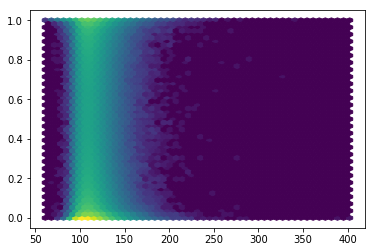

In [61]:
# Color here represents density.
# For more info on Hexbins, check out https://holypython.com/python-visualization-tutorial/creating-hexbin-charts/
plt.hexbin(df.euclidean_distance, df.duplex_yield, gridsize=50, bins='log')


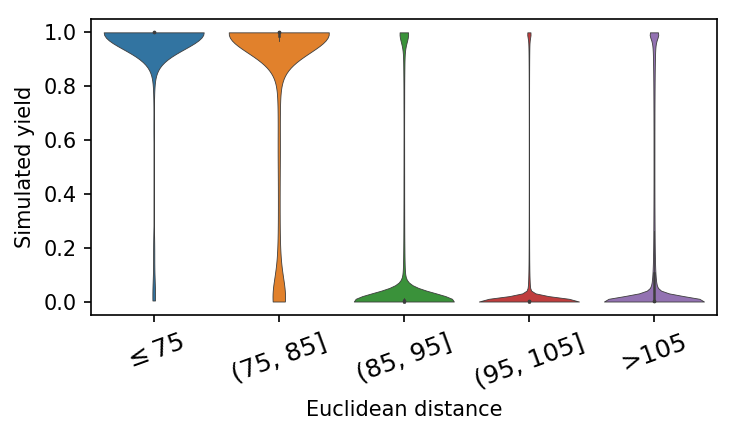

In [62]:
thresholds = [75, 85, 95, 105]
bin_labels = np.array(
    ["$\leq%d$" % thresholds[0]]
    + ["(%d, %d]" % (a,b) for (a,b) in zip(thresholds,thresholds[1:])]
    + [">%d" % thresholds[-1]]
)

plt.figure(figsize = (5, 3), dpi=150)
(lambda data:
    sns.violinplot(

        x='dist_bin',
        y='duplex_yield',
        data=data,
        linewidth=0.4,
        fliersize=0.5,
        cut=0.0,
        scale='width',
        order = bin_labels
    )
)(
    df
    .assign(
        dist_bin = lambda df: bin_labels[np.digitize(df.euclidean_distance, thresholds, right=True)]
    )
)
plt.xlabel("Euclidean distance")
plt.xticks(rotation=20)
[label.set_fontsize(12) for label in plt.gca().get_xticklabels()]
plt.ylabel("Simulated yield")
plt.tight_layout()

In [63]:
def nn_recall(scores, distances, k=10, n_thresholds=500, thresholds=None):
    
    if thresholds is None:
        thresholds = np.linspace(scores.min(), scores.max(), n_thresholds)
        thresholds[0] = (thresholds[0] + thresholds[1])/2
        
    retrieved = scores >= thresholds.reshape(-1,1)
    p_retrieved = retrieved.mean(1)
    
    neighbors = distances.argsort()[:k]
    
    nn_recall = retrieved[:, neighbors].mean(1)
    
    return nn_recall, p_retrieved, thresholds

def nn_recall_discrete(scores, distances, k=100, n_thresholds=500):
    thresholds = np.unique(np.logspace(0, np.log10(scores.max()), n_thresholds).astype(int))
    
    retrieved = scores >= thresholds.reshape(-1,1)
    p_retrieved = retrieved.mean(1)
    
    neighbors = distances.argsort()[:k]
    
    nn_recall = retrieved[:, neighbors].mean(1)
    
    return nn_recall, p_retrieved, thresholds

def plot_baselines(nn_k, n_targets, plt_fn = lambda ax: ax.loglog):
    def plot(ax):
        ax_plot = plt_fn(ax)
        unif = np.linspace(0,1,100)
        ax_plot(unif, unif, alpha=0.2, ls='--', color='black', label='Chance')
        ax_plot(unif, unif * nn_k/n_targets, alpha=0.2, ls='-.', color='black', label='Oracle')
    return plot

In [64]:
n,p,t = nn_recall(
    df.duplex_yield.values/df.duplex_yield.max(),
    df.euclidean_distance.values,
    k=100,
    thresholds=1-np.logspace(-14, 0, 100)
)

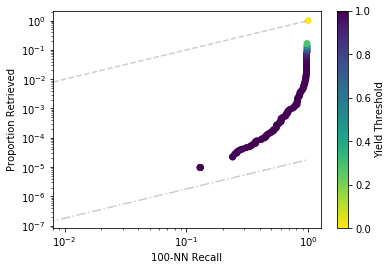

In [65]:
plt.scatter(n,p,c=t, cmap=plt.cm.viridis_r)
plot_baselines(100, len(df))(plt.gca())
plt.xlabel("100-NN Recall")
plt.ylabel("Proportion Retrieved")
plt.colorbar(label="Yield Threshold")

In [66]:
list(t)

[0.99999999999999,
 0.9999999999999861,
 0.9999999999999808,
 0.9999999999999735,
 0.9999999999999633,
 0.999999999999949,
 0.9999999999999295,
 0.9999999999999023,
 0.9999999999998647,
 0.9999999999998126,
 0.9999999999997405,
 0.9999999999996406,
 0.9999999999995023,
 0.9999999999993108,
 0.9999999999990454,
 0.9999999999986781,
 0.9999999999981692,
 0.9999999999974646,
 0.9999999999964888,
 0.9999999999951374,
 0.9999999999932658,
 0.999999999990674,
 0.9999999999870846,
 0.9999999999821135,
 0.9999999999752293,
 0.9999999999656953,
 0.9999999999524919,
 0.9999999999342066,
 0.9999999999088838,
 0.9999999998738143,
 0.9999999998252471,
 0.9999999997579871,
 0.9999999996648398,
 0.9999999995358411,
 0.9999999993571926,
 0.9999999991097849,
 0.9999999987671533,
 0.9999999982926474,
 0.9999999976355106,
 0.9999999967254508,
 0.9999999954651215,
 0.9999999937197086,
 0.9999999913025099,
 0.9999999879549646,
 0.9999999833189946,
 0.999999976898703,
 0.9999999680073286,
 0.999999955693785

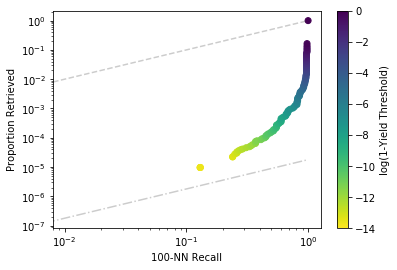

In [67]:
plt.scatter(n,p,c=np.log10(1-t), cmap=plt.cm.viridis_r)
plot_baselines(100, len(df))(plt.gca())
plt.xlabel("100-NN Recall")
plt.ylabel("Proportion Retrieved")
plt.colorbar(label="log(1-Yield Threshold)")

In [68]:
from PIL import Image

In [69]:
tops = df.sort_values('duplex_yield', ascending=False)[:100]

In [70]:
# fig, axarr = plt.subplots(4, 5, figsize = (10,6), dpi=300)
# for ix, ax in enumerate(axarr.flat):
#     if ix < len(tops):
#         imgid = tops.index[ix]
#         img = Image.open('/tf/open_images/extended_targets/images/%s/%s.jpg' % (imgid[:2], imgid))
#         new_height = img.width / 1.5
#         crop = img.crop([0,img.height/2 - new_height/2,img.width,img.height/2 + new_height/2])
#         ax.imshow(crop)
#     ax.set_xticks(())
#     ax.set_yticks(())
# plt.tight_layout()
# plt.savefig('/tf/primo/fig.pdf')

In [71]:
pd.read_hdf('./data/queries/features.h5')

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
callie_janelle,0.000000,0.000000,0.824785,2.219704,0.000000,0.000000,1.675903,0.0,0.0,0.0,...,0.000000,2.061995,0.000000,0.000000,0.0,1.547101,0.000000,0.00000,0.000000,0.0
luis_lego,0.000000,2.985710,0.000000,0.000000,0.000000,0.000000,2.018563,0.0,0.0,0.0,...,1.798746,1.425183,0.000000,0.264251,0.0,0.462136,0.000000,0.00000,0.723953,0.0
yuan_taipei,0.574619,2.315847,0.108085,0.000000,4.347196,1.058487,1.808256,0.0,0.0,0.0,...,0.029271,0.499374,2.675318,0.000000,0.0,1.573474,2.041563,3.67834,1.714135,0.0
